<a href="https://colab.research.google.com/github/Hetvi48/AeroCare/blob/main/All_model_1_aircraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [3]:
# --- 1. Imports ---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import warnings
# warnings.filterwarnings('ignore')

# --- 2. Load and prepare NASA dataset ---
def load_cmapss_train(path_train):
    df = pd.read_csv(path_train, sep='\s+', header=None, engine='python')
    df = df.iloc[:, :26]  # adjust if needed
    cols = ["unit", "cycle"] + [f"op{i}" for i in range(1, 4)] + [f"s{i}" for i in range(1, 22)]
    df.columns = cols
    return df

def make_rul(df):
    df = df.copy()
    max_cycle = df.groupby('unit')['cycle'].transform('max')
    df['RUL'] = max_cycle - df['cycle']
    return df

train_path = "drive/MyDrive/archive/CMaps/train_FD001.txt"  # update path if needed
df = load_cmapss_train(train_path)
df = make_rul(df)

X = df.drop(columns=['unit', 'RUL'])
y = df['RUL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Evaluation helper ---
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) # Removed squared=False
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")
    return mae, rmse, r2

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1299379496.py:13: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(path_train, sep='\s+', header=None, engine='python')


In [4]:
X_train.shape

(16504, 25)

In [5]:
y_train.shape

(16504,)

In [6]:
X_test.shape

(4127, 25)

In [7]:
y_test.shape

(4127,)

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

print("➡ Linear Regression Results:")
evaluate_model(pipe, X_train, y_train, X_test, y_test)

➡ Linear Regression Results:
MAE: 30.543 | RMSE: 1576.332 | R²: 0.655


(30.542623586568503, 1576.3317161165214, 0.6549786818840173)

# Ridge

In [ ]:
from sklearn.linear_model import Ridge

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

param_grid = {'model__alpha': np.logspace(-3, 3, 20)}

search = RandomizedSearchCV(pipe, param_grid, cv=5, n_iter=10,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best Ridge params:", search.best_params_)
best_ridge = search.best_estimator_
evaluate_model(best_ridge, X_train, y_train, X_test, y_test)


Best Ridge params: {'model__alpha': np.float64(483.2930238571752)}
MAE: 30.542 | RMSE: 1578.547 | R²: 0.654


(30.541750272538817, 1578.5473409897847, 0.6544937345811062)

# Lasso

In [ ]:
from sklearn.linear_model import Lasso

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(max_iter=5000))
])

param_grid = {'model__alpha': np.logspace(-4, 1, 20)}

search = RandomizedSearchCV(pipe, param_grid, cv=5, n_iter=10,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best Lasso params:", search.best_params_)
best_lasso = search.best_estimator_
evaluate_model(best_lasso, X_train, y_train, X_test, y_test)


Best Lasso params: {'model__alpha': np.float64(0.8858667904100823)}
MAE: 30.485 | RMSE: 1576.569 | R²: 0.655


(30.485136841459134, 1576.56894643248, 0.6549267578407005)

# Elastic net

In [ ]:
from sklearn.linear_model import ElasticNet

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet(max_iter=5000))
])

param_grid = {
    'model__alpha': np.logspace(-3, 1, 10),
    'model__l1_ratio': np.linspace(0, 1, 10)
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=20, cv=5,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best ElasticNet params:", search.best_params_)
best_en = search.best_estimator_
evaluate_model(best_en, X_train, y_train, X_test, y_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e+07, tolerance: 6.356e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e+07, tolerance: 6.352e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Best ElasticNet params: {'model__l1_ratio': np.float64(0.4444444444444444), 'model__alpha': np.float64(0.05994842503189409)}
MAE: 30.541 | RMSE: 1578.970 | R²: 0.654


(30.54143593098906, 1578.9698355074868, 0.654401260634218)

# kNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance']
}

search = RandomizedSearchCV(pipe, param_grid, cv=5, n_iter=6,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best KNN params:", search.best_params_)
best_knn = search.best_estimator_
evaluate_model(best_knn, X_train, y_train, X_test, y_test)


Best KNN params: {'model__weights': 'uniform', 'model__n_neighbors': 11}
MAE: 27.208 | RMSE: 1458.975 | R²: 0.681


(27.20789920038769, 1458.9752006039648, 0.6806652168040874)

# SVR

In [ ]:
from sklearn.svm import SVR

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR())
])

param_grid = {
    'model__C': [0.1, 1, 10, 50],
    'model__epsilon': [0.01, 0.1, 0.5],
    'model__kernel': ['rbf', 'poly']
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=6, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best SVR params:", search.best_params_)
best_svr = search.best_estimator_
evaluate_model(best_svr, X_train, y_train, X_test, y_test)


Best SVR params: {'model__kernel': 'rbf', 'model__epsilon': 0.01, 'model__C': 50}
MAE: 24.075 | RMSE: 1306.703 | R²: 0.714


(24.075251516273227, 1306.7025368319585, 0.7139940616344643)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=42))
])

param_grid = {
    'model__max_depth': [5, 10, 15, 20, None],
    'model__min_samples_leaf': [1, 3, 5, 10]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=6, cv=5,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best DecisionTree params:", search.best_params_)
best_tree = search.best_estimator_
evaluate_model(best_tree, X_train, y_train, X_test, y_test)


Best DecisionTree params: {'model__min_samples_leaf': 1, 'model__max_depth': 5}
MAE: 27.655 | RMSE: 1438.398 | R²: 0.685


(27.654528500505105, 1438.3981645110714, 0.6851690379497919)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'model__n_estimators': [100, 200, 400],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=6, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

print("Best RandomForest params:", search.best_params_)
best_rf = search.best_estimator_
evaluate_model(best_rf, X_train, y_train, X_test, y_test)


Best RandomForest params: {'model__n_estimators': 400, 'model__min_samples_split': 10, 'model__max_depth': 10}
MAE: 25.261 | RMSE: 1267.580 | R²: 0.723


(25.26061271627884, 1267.580198362392, 0.7225570059998823)

# Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=6, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best GBR params:", search.best_params_)
best_gbr = search.best_estimator_
evaluate_model(best_gbr, X_train, y_train, X_test, y_test)


Best GBR params: {'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.05}
MAE: 25.374 | RMSE: 1272.018 | R²: 0.722


(25.37357508203386, 1272.018133734694, 0.7215856480704501)

# XGBoost

In [ ]:
import xgboost as xgb

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'model__n_estimators': [200, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [4, 6, 10],
    'model__subsample': [0.8, 1],
    'model__colsample_bytree': [0.8, 1]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best XGBoost params:", search.best_params_)
best_xgb = search.best_estimator_
evaluate_model(best_xgb, X_train, y_train, X_test, y_test)


Best XGBoost params: {'model__subsample': 0.8, 'model__n_estimators': 400, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}
MAE: 25.017 | RMSE: 1247.761 | R²: 0.727


(25.016521453857422, 1247.760986328125, 0.7268949747085571)

# light gbm

In [ ]:
import lightgbm as lgb

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'model__n_estimators': [200, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [31, 50, 100],
    'model__max_depth': [-1, 10, 20]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best LightGBM params:", search.best_params_)
best_lgbm = search.best_estimator_
evaluate_model(best_lgbm, X_train, y_train, X_test, y_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 11002, number of used features: 18
[LightGBM] [Info] Start training from score 107.755408


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.070981


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.852677


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 11002, number of used features: 18
[LightGBM] [Info] Start training from score 107.755408


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.070981


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.852677


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 11002, number of used features: 18
[LightGBM] [Info] Start training from score 107.755408


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.070981


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.852677


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 11002, number of used features: 18
[LightGBM] [Info] Start training from score 107.755408


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.070981


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.852677


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 11002, number of used features: 18
[LightGBM] [Info] Start training from score 107.755408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.070981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.852677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 11002, number of used features: 18
[LightGBM] [Info] Start training from score 107.755408


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.070981


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.852677


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 11002, number of used features: 18
[LightGBM] [Info] Start training from score 107.755408


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.070981


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.852677


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 11002, number of used features: 18
[LightGBM] [Info] Start training from score 107.755408


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.070981


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.852677


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 11002, number of used features: 18
[LightGBM] [Info] Start training from score 107.755408


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.070981


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.852677


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3073
[LightGBM] [Info] Number of data points in the train set: 11002, number of used features: 18
[LightGBM] [Info] Start training from score 107.755408


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.070981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 11003, number of used features: 18
[LightGBM] [Info] Start training from score 107.852677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3084
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 18
[LightGBM] [Info] Start training from score 107.559683
Best LightGBM params: {'model__num_leaves': 31, 'model__n_estimators': 400, 'model__max_depth': -1, 'model__learning_rate': 0.01}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3084
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 18
[LightGBM] [Info] Start training from score 107.559683
MAE: 25.410 | RMSE: 1260.178 | R²: 0.724


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(25.41042329544266, 1260.1782220903324, 0.7241771216036847)

# MLP Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(max_iter=500, random_state=42))
])

param_grid = {
    'model__hidden_layer_sizes': [(64,), (128,64), (128,64,32)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01]
}

search = RandomizedSearchCV(pipe, param_grid, n_iter=6, cv=3,
                            scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train, y_train)

print("Best MLP params:", search.best_params_)
best_mlp = search.best_estimator_
evaluate_model(best_mlp, X_train, y_train, X_test, y_test)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best MLP params: {'model__learning_rate_init': 0.001, 'model__hidden_layer_sizes': (64,), 'model__alpha': 0.0001}
MAE: 25.086 | RMSE: 1237.018 | R²: 0.729


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


(25.085881138659076, 1237.017895880233, 0.7292463631822853)

# Results

In [ ]:
results = {
    "Model": ["LinearRegression", "Ridge", "Lasso", "ElasticNet", "KNeighborsRegressor", "SVR", "DecisionTreeRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "xgb", "lgb", "MLPRegressor"],
    "MAE": [30.542623586568503, 30.541750272538817, 30.485136841459134, 30.54143593098906, 27.20789920038769, 24.075251516273227, 27.654528500505105, 25.26061271627884, 25.37357508203386, 25.016521453857422, 25.41042329544266, 25.085881138659076],
    "RMSE": [1576.3317161165214, 1578.5473409897847, 1576.56894643248, 1578.9698355074868, 1458.9752006039648, 1306.7025368319585, 1438.3981645110714, 1267.580198362392, 1272.018133734694, 1247.760986328125, 1260.1782220903324, 1237.017895880233],
    "R2": [0.6549786818840173, 0.6544937345811062, 0.6549267578407005, 0.654401260634218, 0.6806652168040874, 0.7139940616344643, 0.6851690379497919, 0.7225570059998823, 0.7215856480704501, 0.7268949747085571, 0.7241771216036847, 0.7292463631822853]
}

results_df = pd.DataFrame(results)
print(results_df)



                        Model        MAE         RMSE        R2
0            LinearRegression  30.542624  1576.331716  0.654979
1                       Ridge  30.541750  1578.547341  0.654494
2                       Lasso  30.485137  1576.568946  0.654927
3                  ElasticNet  30.541436  1578.969836  0.654401
4         KNeighborsRegressor  27.207899  1458.975201  0.680665
5                         SVR  24.075252  1306.702537  0.713994
6       DecisionTreeRegressor  27.654529  1438.398165  0.685169
7       RandomForestRegressor  25.260613  1267.580198  0.722557
8   GradientBoostingRegressor  25.373575  1272.018134  0.721586
9                         xgb  25.016521  1247.760986  0.726895
10                        lgb  25.410423  1260.178222  0.724177
11               MLPRegressor  25.085881  1237.017896  0.729246


                        Model        MAE         RMSE        R2
5                         SVR  24.075252  1306.702537  0.713994
9                         xgb  25.016521  1247.760986  0.726895
11               MLPRegressor  25.085881  1237.017896  0.729246
7       RandomForestRegressor  25.260613  1267.580198  0.722557
8   GradientBoostingRegressor  25.373575  1272.018134  0.721586
10                        lgb  25.410423  1260.178222  0.724177
4         KNeighborsRegressor  27.207899  1458.975201  0.680665
6       DecisionTreeRegressor  27.654529  1438.398165  0.685169
2                       Lasso  30.485137  1576.568946  0.654927
3                  ElasticNet  30.541436  1578.969836  0.654401
1                       Ridge  30.541750  1578.547341  0.654494
0            LinearRegression  30.542624  1576.331716  0.654979


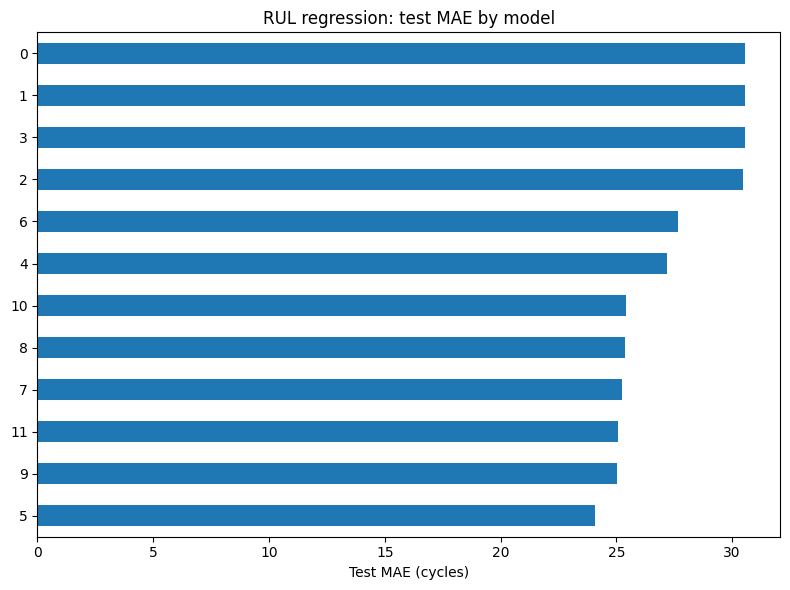

In [ ]:
import matplotlib.pyplot as plt

res = results_df.copy()
res = res.sort_values('MAE')
print(res[['Model','MAE','RMSE','R2']])
res['MAE'].plot.barh(figsize=(8,6))
plt.xlabel("Test MAE (cycles)")
plt.title("RUL regression: test MAE by model")
plt.tight_layout()
plt.show()
